In [1]:
import numpy as np
import random
import torch

import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

import json

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from utils import visualize_cam, Normalize, load_image, plot_gradcam, get_gradcam
# from gradcam import GradCAM, GradCAMpp

from attn_model import *

import matplotlib.pyplot as plt

from helpers import *
# from utils import *

from utils import *

In [17]:
image_names = get_png_names("../pooling/data/MEX2/")[100:105]
y = get_migrants("../pooling/data/migration_data.json" , image_names)

5 municipalities.


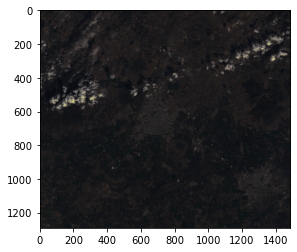

In [22]:
hm = load_inputs(image_names[4])#.to(device)
plt.imshow(hm[0].permute(1,2,0))

In [3]:
# input = load_inputs(image_names[0]).to(device)
# output = torch.tensor([y[0]]).to(device)

In [23]:
def calc_loss_thresholds(loss):
    breaks = loss / 7
    breaks = [(i * breaks) for i in range(7)]
    return breaks



In [24]:
test = (np.array([0]), np.array([1]))

for i, j in zip(test[0], test[1]):
    print(i, j)

0 1


In [25]:
def clip_input(input, test_arr):
    result = np.where(test_arr == np.max(test_arr))
    sh = test_arr.shape
    sh = (int(sh[0] * .70), int(sh[1] * .70))
    
    left = sh[0]
    right = sh[1]
    ni, nj = test_arr.shape 
    new_value = 255

    min_row, max_row = 50000, 0
    min_col, max_col = 50000, 0
    
#     print(result[0].shape)
#     print(result[1].shape)
    
    if (len(result[0]) > 100) or (len(result[1])  > 100):
#         print("Clipping result to first index.")
        result = (np.array([result[0][0]]), np.array([result[1][0]]))


    for i, j in zip(result[0], result[1]):
        istart, istop = max(0, i-left), min(ni, i+left+1)
        jstart, jstop = max(0, j-right), min(nj, j+right+1)
        test_arr[istart:istop, jstart:jstop] = new_value

        if istart < min_row:
            min_row = istart
        if jstart < min_col:
            min_col = jstart   
        if istop > max_row:
            max_row = istop    
        if jstop > max_col:
            max_col = jstop  
            
#     print(min_row, max_row)
#     print(min_col, max_col)
            

    input = input.detach().cpu()[:, :, min_row:max_row, min_col:max_col]
    
    indices = (min_row, max_row, min_col, max_col)
    
    return input, indices

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18().to(device)
model = attnNetBinary(in_channels = 512, h = 7, w = 7, batch_size = 1, resnet = resnet18).to(device)
lr = .0001
criterion = torch.nn.L1Loss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [58]:
BATCH_SIZE = 1

x_train, y_train, x_val, y_val = train_test_split(np.array(image_names), np.array(y), .2)

train = [(k,v) for k,v in zip(x_train, y_train)]
val = [(k,v) for k,v in zip(x_val, y_val)]

train_dl = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_dl = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)

In [59]:
len(val_dl)

4

### Regular t/v (no clipping)

In [60]:
# for i in range(50):
    
#     running_train_loss, running_val_loss = 0, 0
    
#     for input, output in train_dl:
                
#         input = load_inputs(input[0]).to(device)
#         model.train()
#         y_pred = model(input)    
#         loss = criterion(y_pred, output.to(device))
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_train_loss += loss.item()
        
#     for input, output in val_dl:
                
#         input = load_inputs(input[0]).to(device)
#         model.train()
#         y_pred = model(input)    
#         loss = criterion(y_pred, output.to(device))
        
#         running_val_loss += loss.item()

#     print("Epoch: ", i)
#     print("  Train Loss: ", running_train_loss / len(train_dl))
#     print("  Val Loss: ", running_val_loss / len(val_dl))

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18().to(device)
model = attnNetBinary(in_channels = 512, h = 7, w = 7, batch_size = 1, resnet = resnet18).to(device)
lr = .001
criterion = torch.nn.L1Loss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [62]:
sizes_dict = {}

In [63]:
for i, o in val_dl:
    print(i[0].split("/")[4])

484011017
484011014
484011013
484011015


In [64]:
def prep_input(muni_id, sizes_dict, input):
    i = sizes_dict[muni_id]
    input = input.detach().cpu()[:, :, i[0]:i[1], i[2]:i[3]]
    return input

### t/v with clipping

Epoch:  0
  Train Loss:  20868.8916015625
  Loss thresholds based of baseline loss:  [0.0, 2981.2702287946427, 5962.540457589285, 8943.810686383928, 11925.08091517857, 14906.351143973214, 17887.621372767855]


Epoch:  1
  Train Loss:  18601.61083984375


Epoch:  2
  Train Loss:  15453.9228515625
  Moving to threshold:  5   |  Next loss benchmark:  14906.351143973214


Epoch:  3
  Train Loss:  15414.225341796875


Epoch:  4
  Train Loss:  11566.733154296875
  Moving to threshold:  4   |  Next loss benchmark:  11925.08091517857


Epoch:  5
  Train Loss:  12834.67041015625


Epoch:  6
  Train Loss:  9915.8310546875
  Moving to threshold:  3   |  Next loss benchmark:  8943.810686383928


Epoch:  7
  Train Loss:  12520.265380859375


Epoch:  8
  Train Loss:  11147.591796875


Epoch:  9
  Train Loss:  8789.1171875
  Moving to threshold:  2   |  Next loss benchmark:  5962.540457589285


Epoch:  10
  Train Loss:  10835.02392578125


Epoch:  11
  Train Loss:  8467.7548828125


Epoch:  12
  Trai

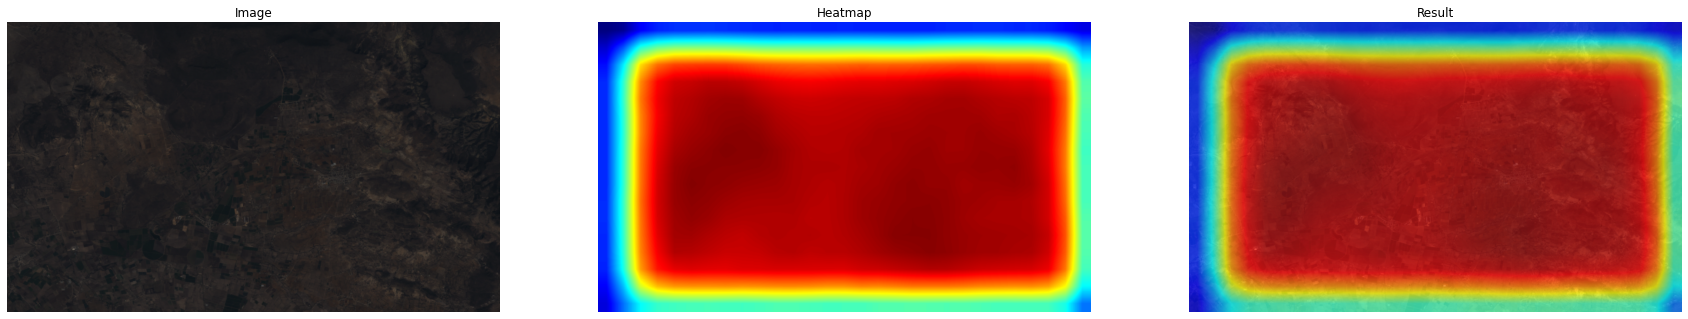

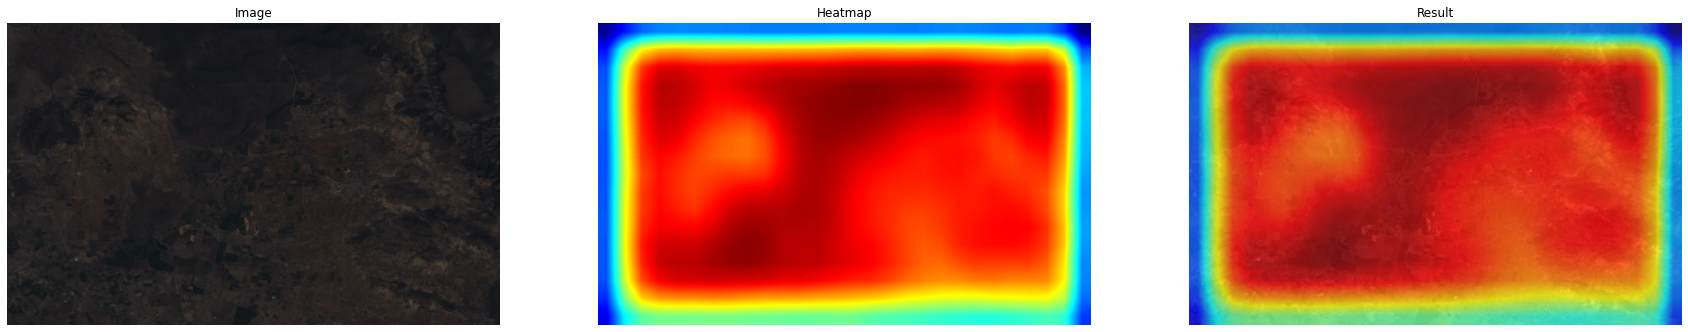

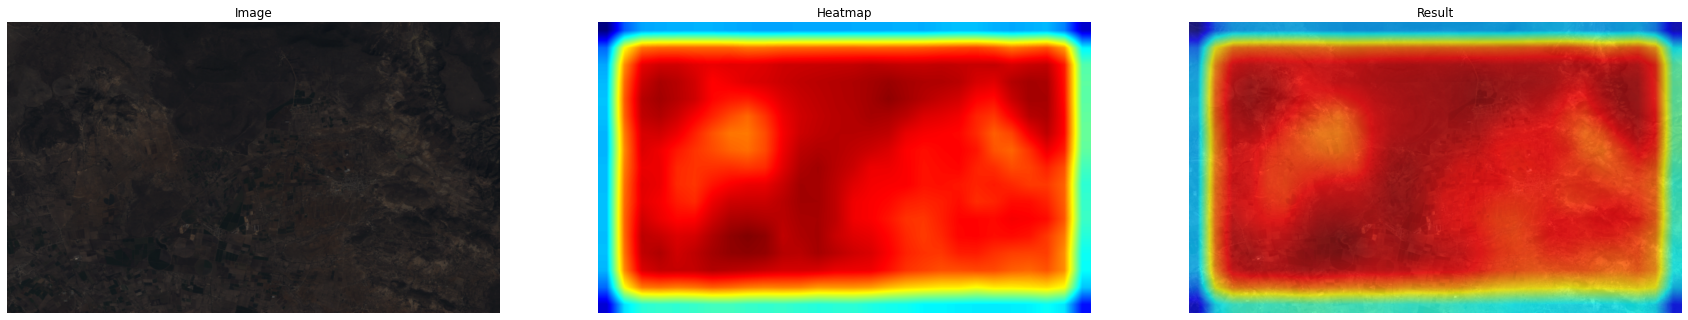

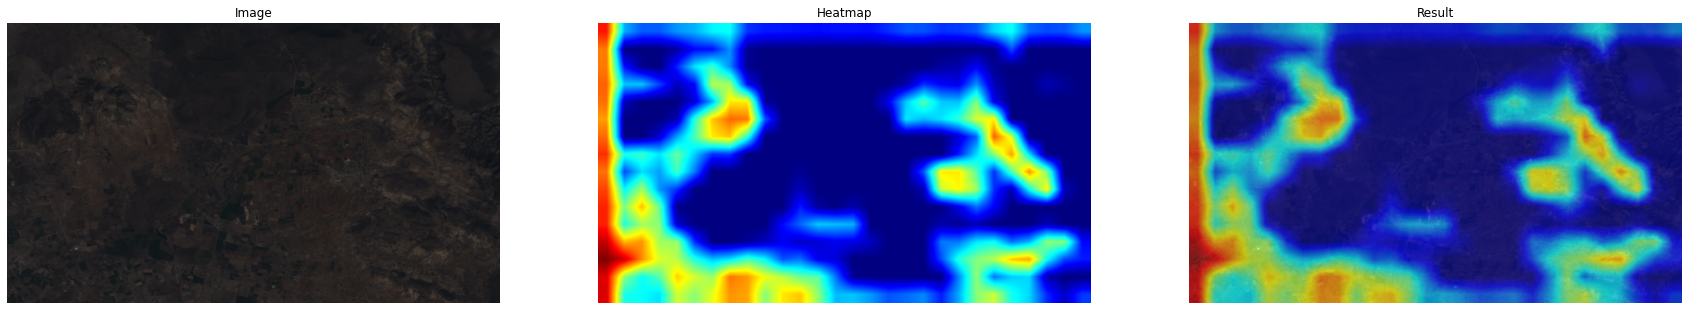

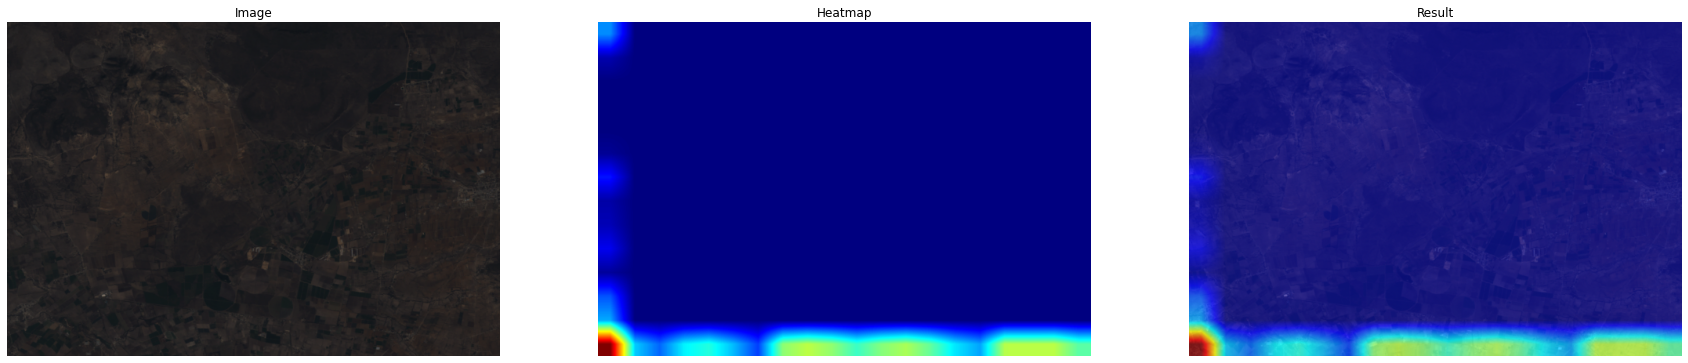

In [65]:
threshold_index = 7

# for i in range(25):
i = 0
while threshold_index > 1:
    
    running_train_loss, running_val_loss = 0, 0
    
    for input, output in val_dl:
        
        muni_id = input[0].split("/")[4]
                
        input = load_inputs(input[0]).to(device)
        
        if (threshold_index < 6):
            input = prep_input(muni_id, sizes_dict, input).to(device)
#             print("Clipping input image.")
        
        model.train()
        y_pred = model(input)    
        loss = criterion(y_pred, output.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        

        
        

    print("Epoch: ", i)
    print("  Train Loss: ", running_train_loss / len(val_dl))
    
    epoch_loss = running_train_loss / len(val_dl)

    
    # After the first epoch...
    if i == 0:

        # Calculate 0, 20, 40, 60, & 80 percent loss thresholds
        loss_thresholds = calc_loss_thresholds(epoch_loss)
        threshold_index = 6
        cur_threshold = loss_thresholds[threshold_index]     

        print("  Loss thresholds based of baseline loss: ", loss_thresholds)
        
        
    # If the loss falls below the current threshold
    if epoch_loss < cur_threshold:
                
        # Set the new threshold
        threshold_index -= 1
        cur_threshold = loss_thresholds[threshold_index]
        print("  Moving to threshold: ", threshold_index, "  |  Next loss benchmark: ", cur_threshold)
        
        for inp, out in val_dl:
            
            muni_id = inp[0].split("/")[4]
            cur_im = load_inputs(inp[0]).to(device)
            
            if muni_id in sizes_dict.keys():
                
                cur_im = prep_input(muni_id, sizes_dict, cur_im).to(device)            
            
            if i == 0:
                
                sizes_dict[muni_id] = (0, cur_im.shape[0], 0, cur_im.shape[1])
                
            if i != 0:
                
                IM_SIZE = (cur_im.shape[2], cur_im.shape[3])
                
#                 print(IM_SIZE)
                model.eval()
                test_ims, test_arr = get_gradcam(model, IM_SIZE, cur_im.cuda())  
                cur_im, new_indices = clip_input(cur_im, test_arr)#.to(device)
#                 print("New image shape: ", cur_im.shape)       
                sizes_dict[muni_id] = new_indices
    
                if muni_id == "484011013":
            
                    plot_gradcam(test_ims)
                    plt.savefig(f"{muni_id}epoch{i}_shape{cur_im.shape}.png")
        
        
        
#         input = clip_input(input, test_arr).to(device)
#         print("New image shape: ", input.shape)
        
#         plot_gradcam(test_ims)
#         plt.savefig(f"./test{i}_imgshape{input.shape}_img{IMAGE_INDEX}.png")
    
#         if threshold_index == 1:
            
#             break        
        
        
    i += 1
    print("\n")

In [244]:
sizes_dict

{'484004001': (772, 2732, 0, 1324), '484002004': (254, 1318, 0, 2752)}

In [161]:
# IMAGE_INDEX = 7

# input = load_inputs(image_names[IMAGE_INDEX]).to(device)
# output = torch.tensor([y[IMAGE_INDEX]]).to(device)

# for i in range(50):
        
#     print("Epoch: ", i)
    
    
#     model.train()
#     y_pred = model(input)    
#     loss = criterion(y_pred, output)
#     print("  Loss: ", loss.item())
    
    
#     IM_SIZE = (input.shape[2], input.shape[3])
#     model.eval()
#     test_ims, test_arr = get_gradcam(model, IM_SIZE, input.cuda())   

    
    
#     # After the first epoch...
#     if i == 0:
        
#         # Calculate 0, 20, 40, 60, & 80 percent loss thresholds
#         loss_thresholds = calc_loss_thresholds(loss)
#         threshold_index = 6
#         cur_threshold = loss_thresholds[threshold_index]
        
#         print("  Loss thresholds based of baseline loss: ", loss_thresholds)
                
    
        
#     # If the loss falls below the current threshold
#     if loss.item() < cur_threshold:
                
#         # Set the new threshold
#         threshold_index -= 1
#         cur_threshold = loss_thresholds[threshold_index]
#         print("  Moving to threshold: ", threshold_index, "  |  Next loss benchmark: ", cur_threshold)
#         input = clip_input(input, test_arr).to(device)
#         print("New image shape: ", input.shape)
        
#         plot_gradcam(test_ims)
#         plt.savefig(f"./test{i}_imgshape{input.shape}_img{IMAGE_INDEX}.png")
    
#         if threshold_index == 1:
            
#             break
            
#     print("\n")


#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

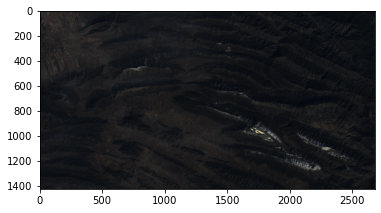

In [10]:
hm = load_inputs(image_names[7])#.to(device)
plt.imshow(hm[0].permute(1,2,0))

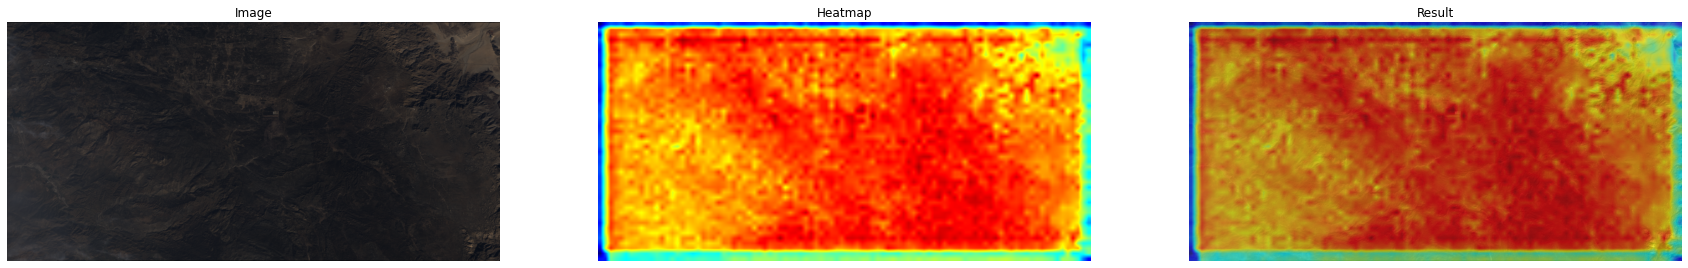

In [10]:
plot_gradcam(test_ims)
plt.savefig("./test.png")